Copyright 2020 Stephan Rabanser, Matthias Anderer

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

In [ ]:
## Only needed when running in colab with data on your gdrive - as you can see not production but competition hack :-)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
import pathlib
package_path = "/content/drive/MyDrive/Colab Notebooks/m5" # gluonts path
sys.path.append(package_path)

###### IF NOT RUN ON COLAB YOU HAVE TO MAKE SURE THAT GLUONTS PACKAGE IS IN YOUR PATH


# Imports


In [ ]:
# Make sure to select the correct MXNet Version (here we have CUDA 10.1 and mkl)
!pip install --upgrade pydantic ujson mxnet-cu101mkl==1.4.1 --no-deps


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 5.2 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 
     |████████████████████████████████| 584.0 MB 25 kB/s 
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.8.2
    Uninstalling pydantic-1.8.2:
      Successfully uninstalled pydantic-1.8.2


In [ ]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

In [ ]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.evaluation import Evaluator


/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaDelta is overriding existing optimizer gluonts.trainer._base.LookaheadAdaDelta
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaGrad is overriding existing optimizer gluonts.trainer._base.LookaheadAdaGrad
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdam is overriding existing optimizer gluonts.trainer._base.LookaheadAdam
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdamax is overriding existing optimizer gluonts.trainer._base.LookaheadAdamax


In [ ]:
class M5Evaluator(Evaluator):
          
        def get_metrics_per_ts(self, time_series, forecast): # y_true of len n+h and y_pred of len h
              # calculate mse of randomwalk hat(yt)=y_{t-1} t=2,...,n
              successive_diff = np.diff(time_series.values.reshape(len(time_series)))
              successive_diff = successive_diff ** 2
              successive_diff = successive_diff[:-prediction_length]
              denom = np.mean(successive_diff)
              # calculate mse of forecast hat(yt), t=n+1,...,n+h
              pred_values = forecast.samples.mean(axis=0)
              true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
              num = np.mean((pred_values - true_values)**2)
              # get rmsse 
              rmsse = num / denom
              # get metrics metadata
              metrics = super().get_metrics_per_ts(time_series, forecast)
              # override
              metrics["RMSSE"] = rmsse
              return metrics
          
        def get_aggregate_metrics(self, metric_per_ts):
              wrmsse = metric_per_ts["RMSSE"].mean()
              agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
              agg_metric["MRMSSE"] = wrmsse
              return agg_metric, metric_per_ts

# Config

In [ ]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
m5_input_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/m5/input/data")
output_parent = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/m5/")
SUBMISSION=True
VISUALIZE=True

VERSION=2

CALC_RESIDUALS = False

prediction_length = single_prediction_length


# Set Seeds

In [ ]:
# Seed value
seed_value= 247

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set gluon seed...
mx.random.seed(seed_value)

# Read Data

In [ ]:
# Load data
print('Loading data...')
sell_price = pd.read_csv('%s/sell_prices.csv' % m5_input_path)
calendar = pd.read_csv('%s/calendar.csv' % m5_input_path)
train = pd.read_csv('%s/sales_train_evaluation.csv' % m5_input_path).set_index('id')
sample_sub = pd.read_csv('%s/sample_submission.csv' % m5_input_path)


Loading data...


# Build aggregate dataset

In [ ]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))


  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [ ]:
%%time
# 1. All products, all stores, all states (1 series)
all_sales = pd.DataFrame(train[ts_cols].sum()).transpose()
all_sales['id_str'] = 'all'
all_sales = all_sales[ ['id_str'] +  [c for c in all_sales if c not in ['id_str']] ]
display(all_sales)

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338


CPU times: user 192 ms, sys: 1.6 ms, total: 193 ms
Wall time: 188 ms


In [ ]:
%%time
# 2. All products by state (3 series)
state_sales = train.groupby('state_id',as_index=False)[ts_cols].sum()
state_sales['id_str'] = state_sales['state_id'] 
state_sales = state_sales[ ['id_str'] +  [c for c in state_sales if c not in ['id_str']] ]
state_sales = state_sales.drop(['state_id'],axis=1)
display(state_sales)

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
1,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
2,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879


CPU times: user 580 ms, sys: 90.2 ms, total: 670 ms
Wall time: 681 ms


In [ ]:
%%time
# 3. All products by store (10 series)
store_sales = train.groupby('store_id',as_index=False)[ts_cols].sum()
store_sales['id_str'] = store_sales['store_id'] 
store_sales = store_sales[ ['id_str'] +  [c for c in store_sales if c not in ['id_str']] ]
store_sales = store_sales.drop(['store_id'],axis=1)
display(store_sales)

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
1,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
2,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
3,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
4,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
5,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
6,TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
7,WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
8,WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068
9,WI_3,4038,4198,3317,3211,2132,4590,4486,5991,4850,...,3987,5674,5894,3897,3306,3268,3398,4126,4519,4757


CPU times: user 630 ms, sys: 6.58 ms, total: 637 ms
Wall time: 642 ms


In [ ]:
%%time
# 4. All products by category (3 series)
cat_sales = train.groupby('cat_id',as_index=False)[ts_cols].sum()
cat_sales['id_str'] = cat_sales['cat_id'] 
cat_sales = cat_sales[ ['id_str'] +  [c for c in cat_sales if c not in ['id_str']] ]
cat_sales = cat_sales.drop(['cat_id'],axis=1)
display(cat_sales)


,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,...,30107,36576,41447,29158,26148,24790,24737,28136,33599,35967
1,HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,...,3871,4893,5016,3528,3629,3740,3475,4143,5333,5280
2,HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,...,10095,12839,13458,9676,9000,8566,8751,10273,12586,13091


CPU times: user 621 ms, sys: 3.05 ms, total: 624 ms
Wall time: 618 ms


In [ ]:
%%time
# 5. All products by department (7 series)
dept_sales = train.groupby('dept_id',as_index=False)[ts_cols].sum()
dept_sales['id_str'] = dept_sales['dept_id'] 
dept_sales = dept_sales[ ['id_str'] +  [c for c in dept_sales if c not in ['id_str']] ]
dept_sales = dept_sales.drop(['dept_id'],axis=1)
display(dept_sales)

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
1,FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
2,FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
3,HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
4,HOBBIES_2,154,185,185,138,100,87,89,155,158,...,449,479,552,419,487,449,448,382,501,560
5,HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
6,HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


CPU times: user 617 ms, sys: 1.14 ms, total: 618 ms
Wall time: 620 ms


In [ ]:
## TOP LEVEL aggregates + TOTAL
all_aggregates = pd.concat([all_sales,state_sales,store_sales,cat_sales,dept_sales],ignore_index=True)
display(all_aggregates)

,id_str,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,...,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338
1,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,...,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644
2,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,...,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815
3,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,...,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879
4,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
5,CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
6,CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
7,CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
8,TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
9,TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217


# Prepare dataframe for gluon-ts


In [ ]:
train_df = all_aggregates.drop(["id_str"], axis=1)


if SUBMISSION == True:
    train_target_values = train_df.values
    test_target_values = [np.append(ts, np.ones(prediction_length) * np.nan) for ts in train_df.values]
else:
    train_target_values = [ts[:-prediction_length] for ts in train_df.values] # list of 1d-arrays
    test_target_values = train_df.values.copy()

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(all_aggregates))]

train_ds = ListDataset([
      {
          FieldName.TARGET: target,
          FieldName.START: start
      }
      for (target, start) in zip(train_target_values, m5_dates)
  ], freq="D")

test_ds = ListDataset([
      {
          FieldName.TARGET: target,
          FieldName.START: start
      }
      for (target, start) in zip(test_target_values,
                                          m5_dates)
  ], freq="D")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(SUBMISSION)
print(train_target_values) # list of 1d-arrays 
print(train_target_values[-1].shape)
print(test_target_values) # 2d-arrays
print(test_target_values.shape)

False
[array([32631, 31749, 23783, ..., 40517, 48962, 49795]), array([14195, 13805, 10108, ..., 17095, 21834, 23187]), array([ 9438,  9630,  6778, ..., 10615, 12266, 12282]), array([ 8998,  8314,  6897, ..., 12807, 14862, 14326]), array([4337, 4155, 2816, ..., 4387, 5577, 6113]), array([3494, 3046, 2121, ..., 4457, 5884, 6082]), array([4739, 4827, 3785, ..., 5623, 7419, 7721]), array([1625, 1777, 1386, ..., 2628, 2954, 3271]), array([2556, 2687, 1822, ..., 3022, 3700, 4033]), array([3852, 3937, 2731, ..., 3902, 4483, 4292]), array([3030, 3006, 2225, ..., 3691, 4083, 3957]), array([2704, 2194, 1562, ..., 3991, 4772, 4874]), array([2256, 1922, 2018, ..., 4988, 5404, 5127]), array([4038, 4198, 3317, ..., 3828, 4686, 4325]), array([23178, 22758, 17174, ..., 26704, 31927, 32654]), array([3764, 3357, 2682, ..., 4085, 4787, 4683]), array([ 5689,  5634,  3927, ...,  9728, 12248, 12458]), array([2343, 2216, 1657, ..., 3169, 3712, 3185]), array([4094, 4209, 3174, ..., 4974, 5524, 6473]), array([

In [ ]:
num_signals = len(train_df)
print(num_signals)

24


In [ ]:
next(iter(train_ds))

/content/drive/MyDrive/Colab Notebooks/m5/gluonts/dataset/common.py:348: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/dataset/common.py:351: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/dataset/common.py:353: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/dataset/common.py:353: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq


{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([32631., 31749., 23783., ..., 40517., 48962., 49795.], dtype=float32)}

# Define Estimators and train on aggregates

In [ ]:
if True:

  estimator = NBEATSEnsembleEstimator(
      prediction_length=prediction_length,
      #context_length=7*prediction_length,
      meta_bagging_size = 3,  # 3, ## Change back to 10 after testing??
      meta_context_length = [prediction_length * mlp for mlp in [3,5,7] ], ## Change back to (2,7) // 3,5,7
      meta_loss_function = ['sMAPE'], ## Change back to all three MAPE, MASE ...
      num_stacks = 30,
      widths= [512],
      freq="D",
      trainer=Trainer(
                    learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=12, #10
                    num_batches_per_epoch=1000,
                    batch_size=16
                    #ctx=mx.context.gpu()
                )

  )
  

TRAINER:gluonts.trainer._base.Trainer(avg_strategy=gluonts.trainer.model_averaging.SelectNBestMean(maximize=False, metric="score", num_models=1), batch_size=16, clip_gradient=10.0, ctx=None, epochs=12, hybridize=True, init="xavier", learning_rate=0.0006, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=1000, patience=10, weight_decay=1e-08)


/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaDelta is overriding existing optimizer gluonts.trainer._base.LookaheadAdaDelta
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdaGrad is overriding existing optimizer gluonts.trainer._base.LookaheadAdaGrad
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdam is overriding existing optimizer gluonts.trainer._base.LookaheadAdam
  Optimizer.opt_registry[name].__name__))
/usr/local/lib/python3.7/dist-packages/mxnet/optimizer/optimizer.py:142: UserWarning: WARNING: New optimizer gluonts.trainer._base.LookaheadAdamax is overriding existing optimizer gluonts.trainer._base.LookaheadAdamax


In [ ]:
if SUBMISSION:
  predictor = estimator.train(train_ds)
else:
  predictor = estimator.train(train_ds,test_ds)

  0%|          | 0/1000 [00:00<?, ?it/s]/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:57: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return ts + offset * ts.freq
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:57: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return ts + offset * ts.freq
100%|██████████| 1000/1000 [01:39<00:00, 10.09it/s, epoch=1/12, avg_epoch_loss=0.437]
2it [00:00, 42.13it/s, epoch=1/12, validation_avg_epoch_loss=0.355]
100%|███

# Analyze forcasts - Errors and Visual inspection


In [ ]:
# (ref: https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html)
# GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:
# - Removes the final window of length prediction_length of the dataset.test that we want to predict
# - The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed
# - The module outputs the forecast sample paths and the dataset.test (as python generator objects)

# kind of like one-shot evaluation 
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/24 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/24 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/transform/split.py:57: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return ts + offset * ts.freq
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/model/n_beats/_ensemble.py:199: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq=start_date.freqstr,


In [ ]:
if not SUBMISSION:
      evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
      agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
      print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 24/24 [00:00<00:00, 344.61it/s]
/content/drive/MyDrive/Colab Notebooks/m5/gluonts/evaluation/_base.py:257: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq


{
    "MSE": 1397690.913457961,
    "abs_error": 452508.48828125,
    "abs_target_sum": 6158820.0,
    "abs_target_mean": 9164.910714285716,
    "seasonal_error": 968.7522228033473,
    "MASE": 0.7810297719763676,
    "MAPE": 0.07901022559913386,
    "sMAPE": 0.08335184747952766,
    "OWA": NaN,
    "MSIS": 31.241190251326856,
    "QuantileLoss[0.5]": 452508.4787597656,
    "Coverage[0.5]": 0.20238095238095236,
    "QuantileLoss[0.67]": 571607.5117077638,
    "Coverage[0.67]": 0.20238095238095236,
    "QuantileLoss[0.95]": 767770.6247985839,
    "Coverage[0.95]": 0.20238095238095236,
    "QuantileLoss[0.99]": 795793.9266687012,
    "Coverage[0.99]": 0.20238095238095236,
    "RMSE": 1182.2397867852194,
    "NRMSE": 0.12899632343852674,
    "ND": 0.0734732445957586,
    "wQuantileLoss[0.5]": 0.07347324304976693,
    "wQuantileLoss[0.67]": 0.09281120599526593,
    "wQuantileLoss[0.95]": 0.12466196849373483,
    "wQuantileLoss[0.99]": 0.12921207742208754,
    "mean_wQuantileLoss": 0.105039

# Visualize forecasts

In [ ]:
num_series = len(all_aggregates)
print(num_series)

24


Plotting time series predictions ...


  0%|          | 0/24 [00:00<?, ?it/s]

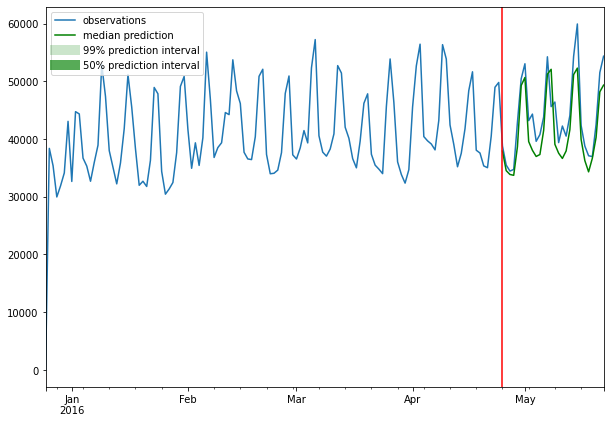

<Figure size 432x288 with 0 Axes>

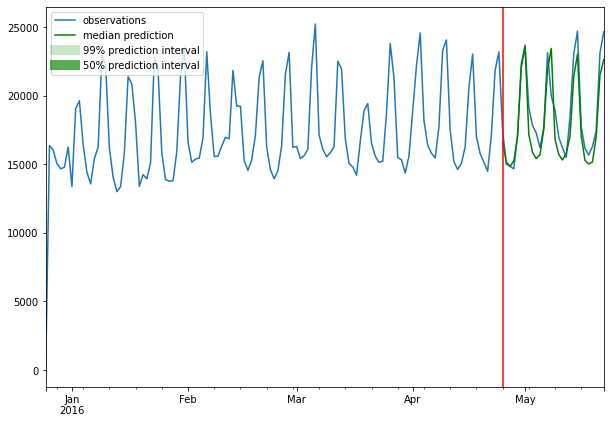

<Figure size 432x288 with 0 Axes>

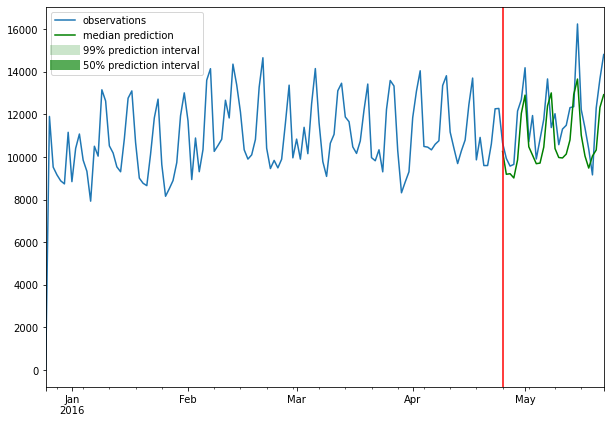

<Figure size 432x288 with 0 Axes>

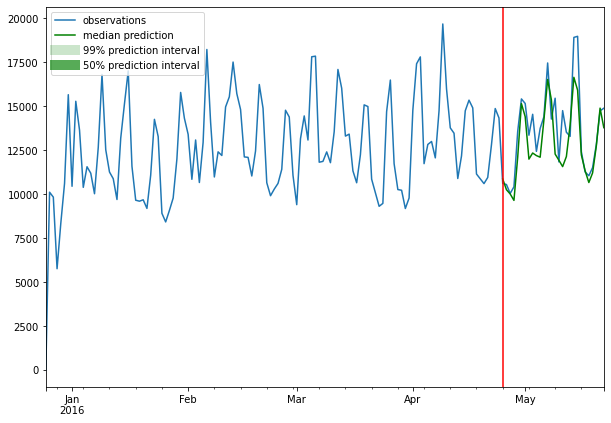

<Figure size 432x288 with 0 Axes>

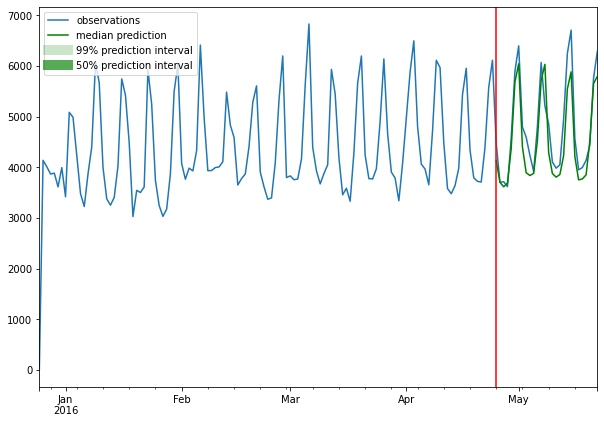

<Figure size 432x288 with 0 Axes>

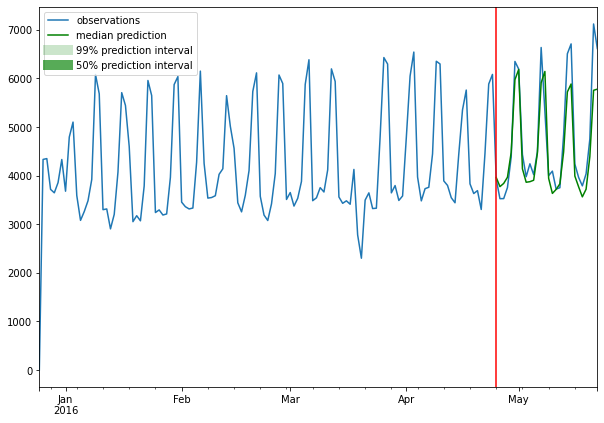

<Figure size 432x288 with 0 Axes>

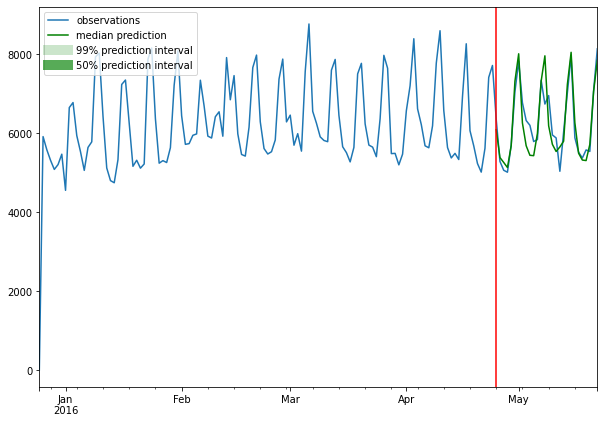

<Figure size 432x288 with 0 Axes>

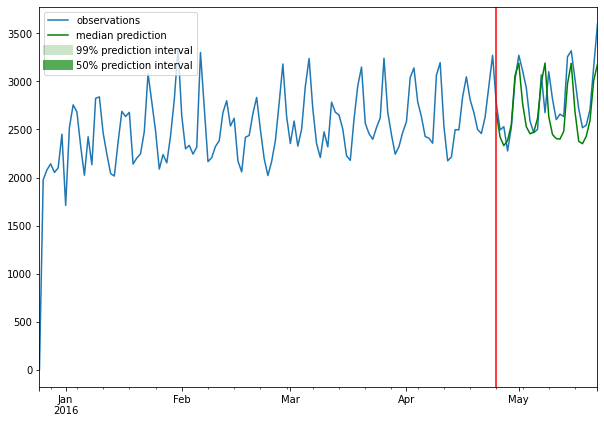

<Figure size 432x288 with 0 Axes>

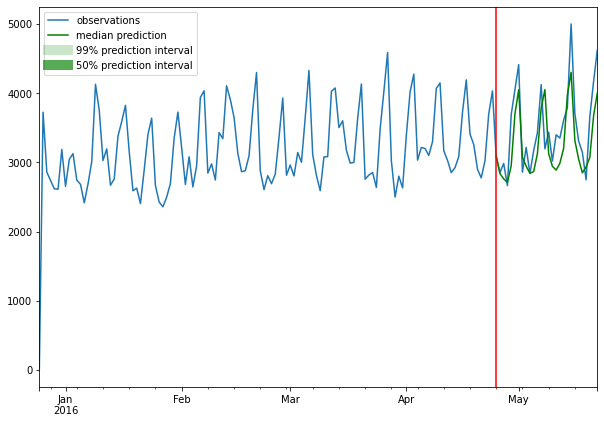

<Figure size 432x288 with 0 Axes>

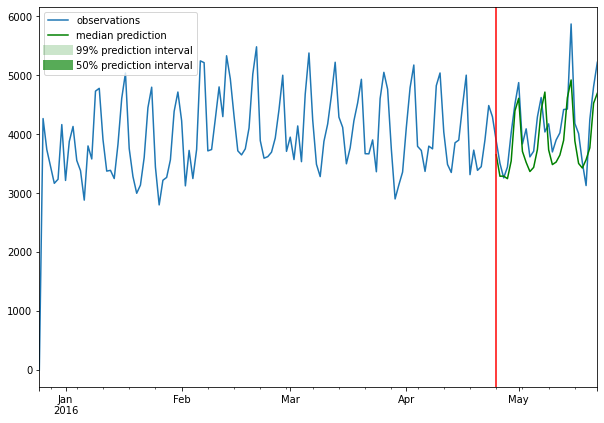

<Figure size 432x288 with 0 Axes>

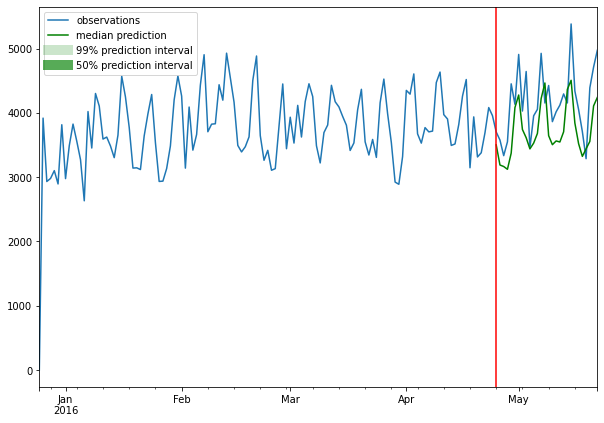

<Figure size 432x288 with 0 Axes>

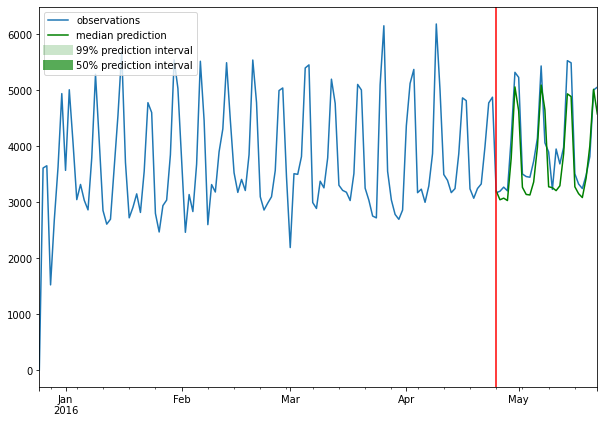

<Figure size 432x288 with 0 Axes>

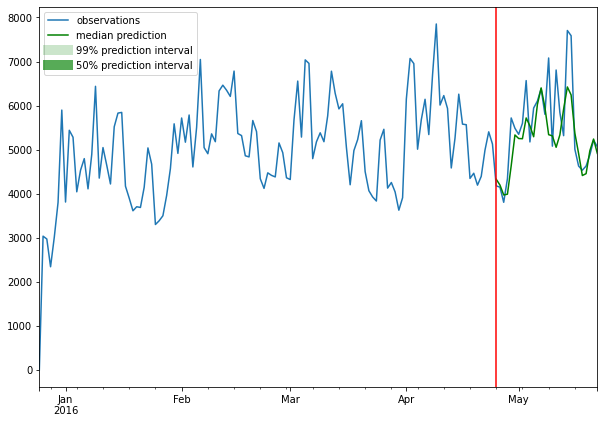

<Figure size 432x288 with 0 Axes>

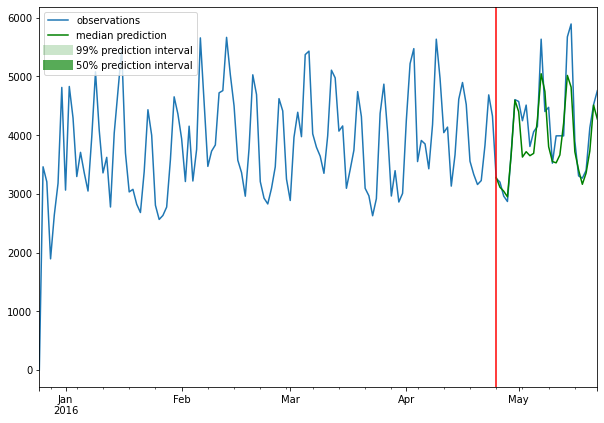

<Figure size 432x288 with 0 Axes>

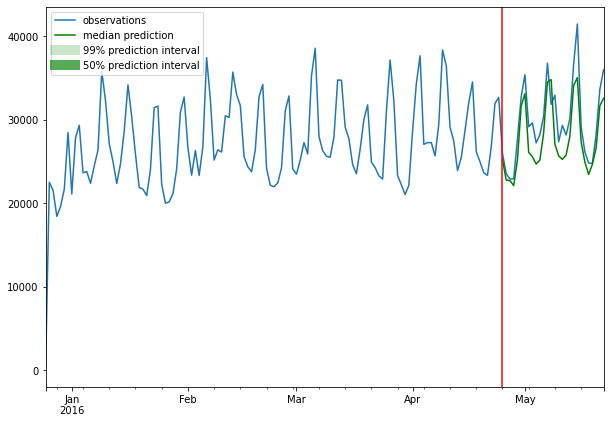

<Figure size 432x288 with 0 Axes>

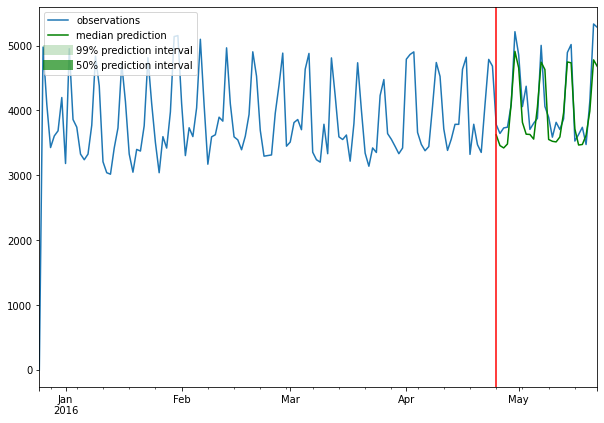

<Figure size 432x288 with 0 Axes>

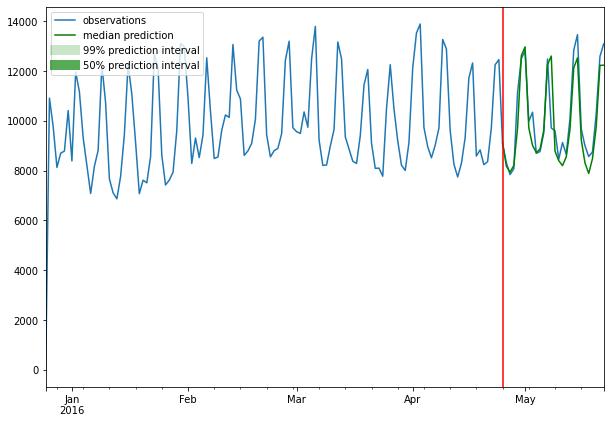

<Figure size 432x288 with 0 Axes>

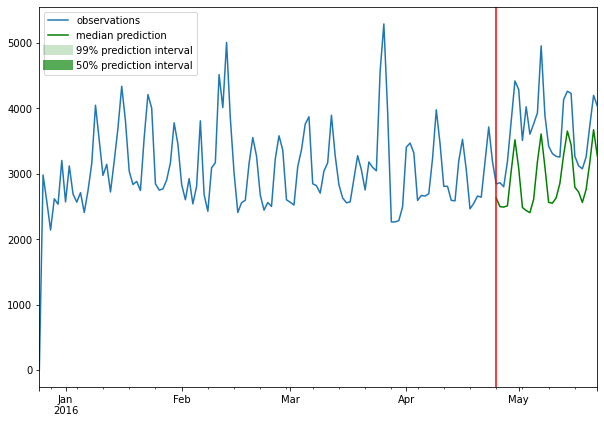

<Figure size 432x288 with 0 Axes>

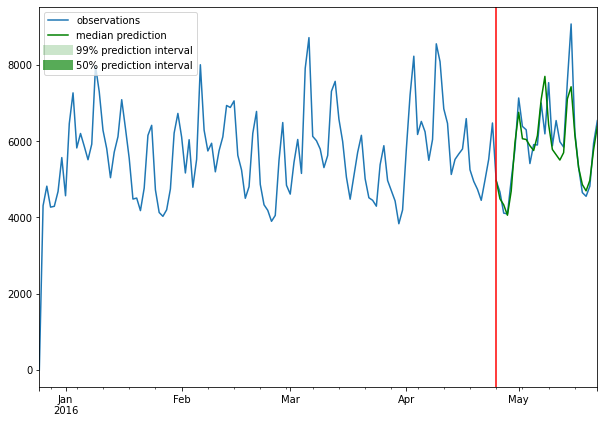

<Figure size 432x288 with 0 Axes>

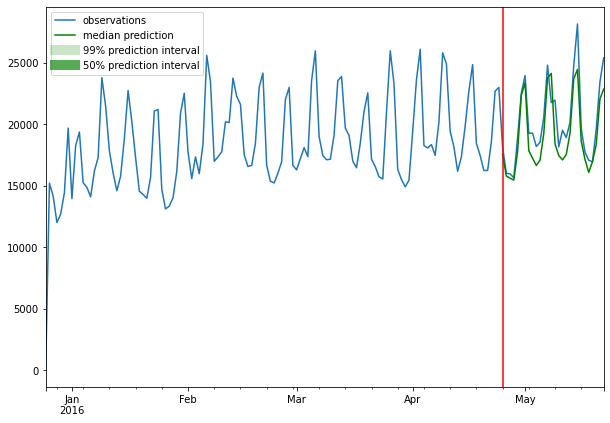

<Figure size 432x288 with 0 Axes>

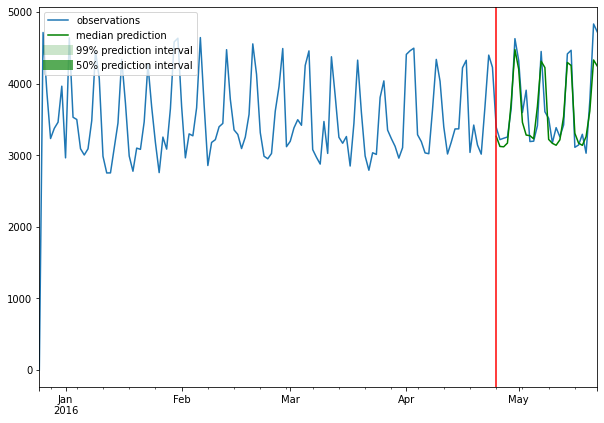

<Figure size 432x288 with 0 Axes>

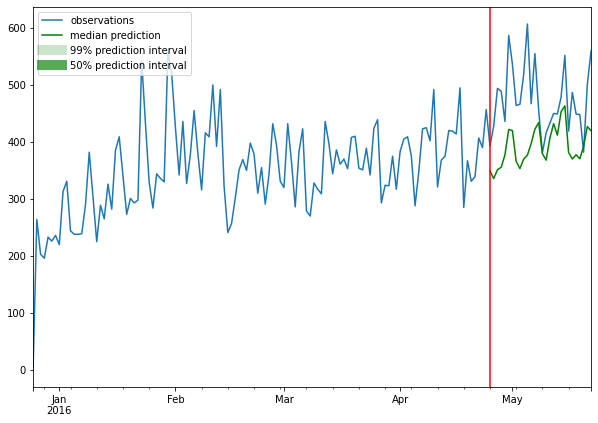

<Figure size 432x288 with 0 Axes>

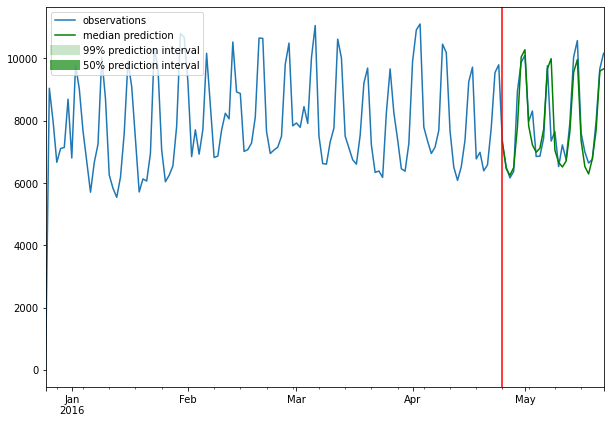

<Figure size 432x288 with 0 Axes>

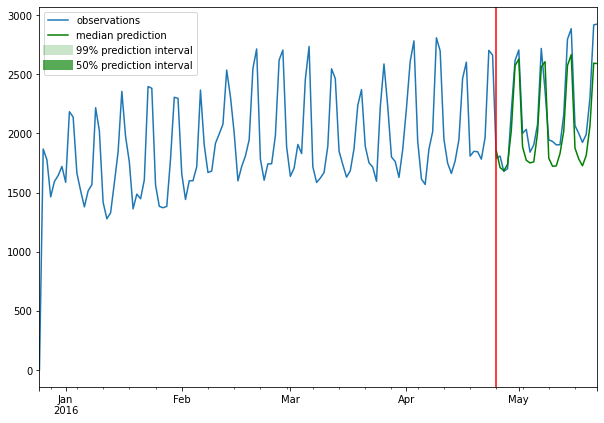

<Figure size 432x288 with 0 Axes>

In [ ]:
# Again, model is trained on training data to learn 1-in-n-out forecast, ie, 
# being able to take 1 data point as input and output n=prediction_horizon forecast. 
# The test visualizatoin is based on ``make_evaluation_predictions``, thus the test prediction
# length must equal to prediction_horizon (like one-shot evaluation), no any recursive strategy 
# involved for collecting the test predictions. 

if VISUALIZE:
  
  plot_log_path = output_parent/"plots/"
  directory = os.path.dirname(plot_log_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
      
  def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
      plot_length = 150
      prediction_intervals = (50, 99)
      legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

      _, ax = plt.subplots(1, 1, figsize=(10, 7))
      ts_entry[-plot_length:].plot(ax=ax)
      forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
      ax.axvline(ts_entry.index[-prediction_length], color='r')
      plt.legend(legend, loc="upper left")
      if inline:
          plt.show()
          plt.clf()
      else:
          plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
          plt.close()

  print("Plotting time series predictions ...")
  for i in tqdm(range(num_series)):
      ts_entry = tss[i]
      forecast_entry = forecasts[i]
      plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)


# Predict and save forecast


In [ ]:
forecasts_acc = np.zeros((len(forecasts), prediction_length))

for i in range(len(forecasts)):
    forecasts_acc[i] = forecasts[i].samples

columns = []
for i in range(1,(forecasts_acc.shape[1]+1)):
    columns.append("F"+str(i))
forecasts_acc_df = pd.DataFrame(data=forecasts_acc, columns=columns)

In [ ]:
forecasts_acc_df = pd.concat([all_aggregates['id_str'],forecasts_acc_df],axis=1)

In [ ]:
forecasts_acc_df

,id_str,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,all,37913.140625,34519.093750,33859.378906,33712.636719,38665.464844,49269.890625,50652.292969,39555.984375,38043.480469,...,41620.148438,51148.855469,52275.390625,39940.871094,36255.328125,34314.648438,36673.191406,40275.734375,48174.832031,49331.992188
1,CA,16622.892578,15164.807617,14839.756836,15238.473633,17020.302734,22080.435547,23554.017578,17175.568359,15858.761719,...,17017.820312,21377.580078,23030.412109,17048.144531,15272.625000,15020.638672,15164.720703,17012.021484,21499.207031,22616.080078
2,TX,10259.706055,9190.710938,9217.961914,9018.182617,9867.200195,12047.592773,12907.983398,10481.132812,10086.388672,...,10802.969727,12937.149414,13662.270508,11033.260742,10050.900391,9482.541016,10048.020508,10330.768555,12335.068359,12928.801758
3,WI,10856.208008,10247.426758,10004.953125,9640.068359,12089.540039,15141.327148,14402.012695,11986.872070,12333.397461,...,13938.888672,16637.105469,15905.347656,12225.410156,11328.048828,10656.640625,11201.078125,12740.486328,14885.439453,13772.950195
4,CA_1,4132.250000,3703.199951,3615.097900,3687.511719,4365.584473,5684.063965,6041.330566,4404.061035,3893.230225,...,4228.672852,5547.421875,5883.698242,4212.598633,3751.676758,3769.563965,3850.071533,4519.581543,5652.137207,5794.764160
5,CA_2,3962.197021,3773.439941,3839.454346,3966.085205,4478.204102,5973.539062,6183.770508,4139.447754,3863.425781,...,4487.042969,5722.512207,5884.974121,3990.406250,3770.012451,3563.101074,3720.228516,4390.491699,5754.971191,5779.120117
6,CA_3,6092.508789,5387.148926,5262.924316,5134.841309,5685.743652,7323.485840,8017.473145,6262.953125,5686.477539,...,5801.603027,7240.293457,8054.790527,6272.323242,5495.133301,5324.025879,5310.734375,5720.657715,7060.154297,7852.029297
7,CA_4,2667.245850,2421.739502,2331.864746,2384.694580,2550.077881,3062.577148,3189.171631,2775.338623,2529.058105,...,2480.023926,2975.081299,3188.377686,2686.178467,2376.757568,2352.194580,2428.739258,2590.395508,3007.741211,3177.406006
8,TX_1,3094.382080,2837.979004,2760.253906,2711.100342,2950.044678,3700.175293,4048.943359,3076.302246,2943.833252,...,3201.398682,3973.096924,4302.018066,3315.974121,3049.413574,2848.566650,2934.718994,3073.520752,3673.442139,4004.295898
9,TX_2,3647.599609,3284.044434,3286.213867,3242.987305,3542.832275,4392.577148,4605.136719,3705.618896,3518.056152,...,3892.217773,4616.486328,4916.588379,3883.034180,3500.669678,3423.608398,3564.201660,3766.281250,4521.230957,4691.692871


In [ ]:
forecasts_acc_df.to_csv(output_parent/f'nbeats_toplvl_forecasts{VERSION}.csv', index=False)